In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split
from torchvision import transforms
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

from collections import namedtuple, defaultdict
from datetime import datetime
from sklearn.metrics import confusion_matrix

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import seaborn as sns
from tqdm import tqdm as tqdm

##### **Loading CIFAR10 dataset** (Canadian Institute for Advanced Research)

**Note**: The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
Links: [[1](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10)][[2](https://www.cs.toronto.edu/~kriz/cifar.html)]

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Dataset visualization

In [ ]:
print(f"Length of trainset: {len(trainloader.dataset)} and testset: {len(testloader.dataset)} ")

Length of trainset: 50000 and testset: 10000 


In [ ]:
print(f"Unique classes: {np.unique(trainloader.dataset.targets)}")

Unique classes: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
print(f"Shape of image: {trainloader.dataset.data[0].shape}")

Shape of image: (32, 32, 3)


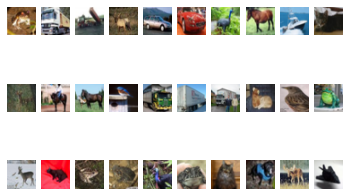

In [ ]:
fig, axes = plt.subplots(3,10)
[axi.set_axis_off() for axi in axes.ravel()]
for i, ax in enumerate(axes.flat):
    ax.imshow(trainloader.dataset.data[i])

### Splitting train into train and validation set

In [ ]:
train_val_set = CIFAR10(root='./data', train=True, download=True, transform=transform)

val_size = 5000
train_size = len(train_val_set) - val_size
trainset, valset = random_split(train_val_set, [train_size, val_size])

Files already downloaded and verified


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True)


In [ ]:
print("Train, val and test sizes: ")
print(f"{len(trainset)}, {len(valset)}, {len(testset)}")

Train, val and test sizes: 
45000, 5000, 10000




---



---



### Let's start by defining some activation functions:

In [ ]:
ActivationFunction = namedtuple('Activations', 'name func')
activation_dict = {'relu': ActivationFunction('relu', F.relu), 'sigmoiod': ActivationFunction('sigmoid', F.sigmoid)}

Testing ReLU activation

In [ ]:
x = np.arange(-5, 5, 0.1)
relu_x = activation_dict['relu'].func(torch.Tensor(x))

Text(0, 0.5, 'ReLU(x)')

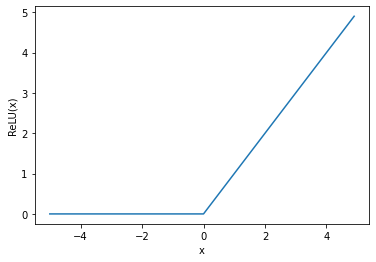

In [ ]:
plt.plot(x, relu_x.numpy())
plt.xlabel('x')
plt.ylabel('ReLU(x)')

Try out the following:


1.   Plot Sigmoid curve
2.   Add tanh activation function to the activation dict and plot



### MLP 

In this toy example, we will define a two hidden layer MLP with ReLU activation function.

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        hparams = {'num_layers': 2, 'hidden_sizes': [50, 30, output_size], 'activation_func': 'relu'}
        num_layers = hparams['num_layers']
        hidden_sizes = hparams['hidden_sizes']
        activation_func = hparams['activation_func']
        
        if len(hidden_sizes) == num_layers-1:
            hidden_sizes.append(output_size)
        elif hidden_sizes[-1] != output_size:
            print("Last layer size {} is not equal to the output size {}!".format(hidden_sizes[-1], output_size))
            raise ValueError('Last layer size!= output size!')
        
        hidden_sizes = [input_size] + hidden_sizes

        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.activation_func = activation_dict[activation_func].func

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x
        

In [ ]:
model = FeedForwardNetwork(32*32*3, 10)
print(model)

FeedForwardNetwork(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=30, out_features=10, bias=True)
)


In [ ]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_ver

In [ ]:
32*32*3

3072

In [ ]:
model.state_dict()['fc1.weight'].shape, model.state_dict()['fc1.bias'].shape

(torch.Size([50, 3072]), torch.Size([50]))

In [ ]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-2.1390e-03, -1.7736e-02, -1.4439e-02,  ...,  1.4507e-02,
                        4.0283e-03, -1.7033e-02],
                      [-1.1094e-03, -8.7523e-03, -1.2218e-02,  ..., -1.3244e-02,
                       -1.3292e-02, -1.2207e-02],
                      [ 3.9284e-03,  4.3397e-03,  1.7103e-02,  ...,  3.9256e-03,
                       -3.8224e-03, -6.1968e-03],
                      ...,
                      [ 1.5142e-03,  1.1131e-02, -6.6393e-03,  ...,  1.6301e-02,
                        6.2954e-05,  4.6888e-03],
                      [-6.4785e-03,  1.1522e-02,  1.4523e-02,  ..., -9.0570e-03,
                        1.3937e-03,  1.2525e-02],
                      [-1.5978e-02,  9.1471e-04,  3.2694e-03,  ..., -9.4316e-03,
                       -8.9484e-03, -1.2853e-02]])),
             ('fc1.bias',
              tensor([ 0.0140,  0.0005,  0.0179,  0.0156, -0.0061,  0.0134,  0.0018,  0.0088,
                      -0.0147,  0.00

### Setting up the Model Trainer 

In [ ]:
!mkdir ckpt

In [ ]:
def model_trainer():
    model_save_loc = "./ckpt/{}_{}"

    lr         = 2e-4
    num_epochs = 2

    mlp           = FeedForwardNetwork(32*32*3, 10)
    loss_function = nn.CrossEntropyLoss()
    optimizer     = torch.optim.Adam(mlp.parameters(), lr=lr)

    for epoch in range(num_epochs):
        train_running_loss = []
        val_running_loss   = []

        # Start training
        mlp.train()
        for step_idx, data in enumerate(tqdm(trainloader, desc="Training")):
            optimizer.zero_grad()       #  clear out gradients computed previously

            data_x, targets = data
            inputs  = torch.flatten(data_x, 1)
            targets = targets.type(torch.LongTensor)
            outputs = mlp(inputs)

            # compute loss
            loss = loss_function(outputs, targets)
            loss.backward()             # store the gradients
            optimizer.step()            #  iterate over all parameters and update their values
            train_running_loss.append(loss.item())

            if step_idx % 3000 == 0:
                torch.save(mlp.state_dict(), model_save_loc.format(epoch, step_idx))
                print(f"Saved checkpoint at step {step_idx}")

        print("Epoch: {}/{} - Train loss: {:.4f}".format(epoch+1, num_epochs, np.mean(train_running_loss)))

        # Validation
        mlp.eval()
        with torch.no_grad():
            for step_idx, data in enumerate(tqdm(valloader, desc="Validation")):
                data_x, targets = data
                inputs  = torch.flatten(data_x, 1)
                targets = targets.type(torch.LongTensor)
                outputs = mlp(inputs)
                loss = loss_function(outputs, targets)
                val_running_loss.append(loss.item())
            
            print("Epoch: {}/{} - Validation loss: {:.4f}".format(epoch+1, num_epochs, np.mean(val_running_loss)))

    torch.save(mlp.state_dict(), './pytorch_model.bin')

```model.eval()``` will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.

```torch.no_grad()``` impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).

In [ ]:
model_trainer()

Training:   0%|          | 45/11250 [00:00<00:49, 224.57it/s]

Saved checkpoint at step 0


Training:  27%|██▋       | 3035/11250 [00:11<00:30, 266.18it/s]

Saved checkpoint at step 3000


Training:  54%|█████▎    | 6029/11250 [00:22<00:19, 263.61it/s]

Saved checkpoint at step 6000


Training:  80%|████████  | 9037/11250 [00:34<00:08, 259.41it/s]

Saved checkpoint at step 9000


Training: 100%|██████████| 11250/11250 [00:42<00:00, 263.88it/s]


Epoch: 1/2 - Train loss: 1.6949


Validation: 100%|██████████| 1250/1250 [00:02<00:00, 559.18it/s]


Epoch: 1/2 - Validation loss: 1.5812


Training:   0%|          | 26/11250 [00:00<00:44, 253.23it/s]

Saved checkpoint at step 0


Training:  27%|██▋       | 3053/11250 [00:11<00:31, 259.37it/s]

Saved checkpoint at step 3000


Training:  54%|█████▎    | 6037/11250 [00:22<00:19, 265.93it/s]

Saved checkpoint at step 6000


Training:  80%|████████  | 9043/11250 [00:34<00:09, 240.00it/s]

Saved checkpoint at step 9000


Training: 100%|██████████| 11250/11250 [00:43<00:00, 261.00it/s]


Epoch: 2/2 - Train loss: 1.5052


Validation: 100%|██████████| 1250/1250 [00:02<00:00, 545.95it/s]

Epoch: 2/2 - Validation loss: 1.5327


Try out the following: 

1.   Explore how to use a Sequential container for the model architecture.
https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
2.   Plot the train and validation loss for each batch and epoch.
3.   Plot confusion matrix for each class' accuracy on the test set.
4.   Use tensorboard/wandb for plots.



In [ ]:
!pwd

/content


References:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html